Cindy Liu, BE205

#Final Project: Automated Classification of Breast Cancer with Photoacoustic Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, BatchNormalization, Conv2D, MaxPool2D, Softmax
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, roc_curve, auc, recall_score, precision_score, f1_score
import seaborn as sns
import pickle


gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Approach 1: Feature-Based Models
In this approach, 1D and 2D features chosen based on literature review are extracted and used to train non-deep learning models. 
- 1D features: mean, std, variance, range, IQR, mean absolute deviation (MAD), percentiles (25/50/75), skewness, kurtosis, GLCM (Gray-level cooccurrence matrix - contrast, correlation, energy, homogeneity), Hu's moments
- 2D features: density, entropy, directionality, FD (fractal), branching, endpoints

## Feature comparison
Features were extracted separately using MATLAB (due to existing lab code pipelines for image processing).

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/BE 205/breast_pact/feature_means_sections_train.csv')
train_df

'density'  'entropy'  'directionality'      'FD'  'segmentation'  \
0    0.000632   0.921031         -0.215153  1.764864        0.003265   
1    0.000732   1.036322         -0.223389  1.756083        0.004349   
2    0.000761   0.731134         -0.221955  1.782538        0.000656   
3    0.000627   0.658455         -0.215303  1.770811        0.000565   
4    0.000654   0.490439         -0.228829  1.779980        0.000122   
..        ...        ...               ...       ...             ...   
67   0.000744   1.767879         -0.267672  1.743222        0.001709   
68   0.000625   2.616184         -0.274986  1.736514        0.010635   
69   0.000727   3.260091         -0.279810  1.699840        0.017761   
70   0.001070   1.490817         -0.225677  1.718765        0.002945   
71   0.001021   1.444839         -0.226285  1.730107        0.001266   

    '1d-mean'  '1d-std'  '1d-variance'  '1d-range'  '1d-iqr'  ...  \
0    0.037770  0.052337       0.002739    0.624273  0.022836  ...   
1    0.047497  0.065543       0.004296    0.694362  0.024326  ...   
2    0.039395  0.055074       0.003033    0.816705  0.026657  ...   
3    0.039929  0.058297       0.003399    0.911065  0.026724  ...   
4    0.038227  0.046019       0.002118    0.937485  0.023505  ...   
..        ...       ...            ...         ...       ...  ...   
67   0.100538  0.069174       0.004785    0.885466  0.045020  ...   
68   0.132993  0.115636       0.013372    0.934217  0.116699  ...   
69   0.148825  0.107980       0.011660    0.852414  0.091774  ...   
70   0.078411  0.101563       0.010315    0.941912  0.072192  ...   
71   0.075171  0.088683       0.007865    0.917808  0.069609  ...   

    '1d-glcm-135-homogeneity'  '1d-moments-1'  '1d-moments-2'  '1d-moments-3'  \
0                    0.948530       -0.579324        1.448735       -0.549950   
1                    0.936433       -0.454049        0.430392        0.357060   
2                    0.949096       -0.538234        1.112296       -0.160735   
3                    0.933467       -0.574034        1.602329        0.786723   
4                    0.953288       -0.633428        1.211099        2.108047   
..                        ...             ...             ...             ...   
67                   0.883120       -0.172685        2.216872        3.782824   
68                   0.836750       -0.008859        1.311966        1.326897   
69                   0.809808        0.026586        2.021840        2.677815   
70                   0.840453       -0.258975        1.702808        0.874373   
71                   0.867162       -0.289298        1.433186        0.661103   

    '1d-moments-4'  '1d-moments-5'  '1d-moments-6'  '1d-moments-7'  \
0        -0.250857       -0.355319       -0.662812       -0.261570   
1         0.926419        2.252979        1.693029        1.755639   
2         0.136880       -0.166953       -0.835973       -0.367011   
3         0.390056        1.825437       -1.528162       -0.988547   
4         0.383362        2.121925        1.071510        1.792316   
..             ...             ...             ...             ...   
67        2.627898       -6.555314        4.129370       -5.941125   
68        2.090548       -4.953986        3.884157        3.987824   
69        2.676956       -5.560282        3.748107       -5.377980   
70        1.172374        2.257200       -2.190444        2.520714   
71        0.943059       -2.870627       -2.206460       -2.409186   

    '1d-moments-8'  label  
0        -0.617021      0  
1        -0.909654      0  
2        -0.278485      0  
3        -0.552480      0  
4        -0.823029      0  
..             ...    ...  
67       -3.564961      1  
68        3.139342      1  
69       -3.527587      1  
70       -2.465631      1  
71       -0.981543      1  

[72 rows x 43 columns]

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/BE 205/breast_pact/feature_means_sections_test.csv')
test_df

'density'  'entropy'  'directionality'      'FD'  'segmentation'  \
0    0.000666   0.390343         -0.305533  1.585324        0.001709   
1    0.000593   0.317559         -0.309830  1.580154        0.005005   
2    0.000532   0.305941         -0.313825  1.650609        0.008392   
3    0.000781   0.437338         -0.301768  1.516660        0.001831   
4    0.000605   0.904546         -0.241347  1.739627        0.000351   
5    0.000572   1.092739         -0.227639  1.769394        0.001968   
6    0.000439   1.002359         -0.241822  1.717751        0.002350   
7    0.000754   3.022823         -0.309445  1.725261        0.008224   
8    0.000867   3.275239         -0.299235  1.694024        0.005753   
9    0.000903   3.138689         -0.302203  1.732002        0.002945   
10   0.000968   3.927109         -0.279288  1.750381        0.008652   
11   0.000837   1.263921         -0.196260  1.796005        0.000992   
12   0.000599   0.787471         -0.213020  1.800577        0.000641   
13   0.000541   0.901786         -0.218647  1.775088        0.001114   
14   0.000725   3.139101         -0.274760  1.722762        0.005417   
15   0.000829   3.802248         -0.288890  1.754037        0.001343   
16   0.000547   1.925468         -0.241370  1.773867        0.003403   
17   0.000610   3.504225         -0.273316  1.744837        0.010284   
18   0.000579   1.212314         -0.228039  1.758944        0.002304   
19   0.000518   0.901302         -0.263908  1.751138        0.002808   
20   0.000541   1.338496         -0.247780  1.745554        0.004623   
21   0.000775   1.600965         -0.252700  1.699416        0.003494   
22   0.000719   1.145028         -0.270804  1.723674        0.000763   
23   0.000718   2.260481         -0.228983  1.772457        0.009796   
24   0.000767   1.062144         -0.206807  1.820047        0.000793   
25   0.000521   1.261259         -0.243730  1.761869        0.002777   
26   0.000754   3.712327         -0.277240  1.611897        0.022430   
27   0.000680   3.667031         -0.287255  1.624897        0.022354   

    '1d-mean'  '1d-std'  '1d-variance'  '1d-range'  '1d-iqr'  ...  \
0    0.022318  0.018860       0.000356    0.266863  0.005179  ...   
1    0.021813  0.015602       0.000243    0.252953  0.005158  ...   
2    0.021439  0.013809       0.000191    0.222445  0.005271  ...   
3    0.022845  0.018270       0.000334    0.270053  0.005134  ...   
4    0.060472  0.062259       0.003876    0.944681  0.050090  ...   
5    0.059178  0.076882       0.005911    0.878529  0.058628  ...   
6    0.057913  0.066078       0.004366    0.823802  0.040995  ...   
7    0.101995  0.024264       0.000589    0.252709  0.016799  ...   
8    0.109627  0.028394       0.000806    0.326533  0.013414  ...   
9    0.103108  0.025051       0.000628    0.331066  0.018552  ...   
10   0.113146  0.036111       0.001304    0.387769  0.021250  ...   
11   0.054090  0.058068       0.003372    0.750287  0.047872  ...   
12   0.049667  0.065315       0.004266    0.924575  0.035593  ...   
13   0.050448  0.062095       0.003856    0.815730  0.042056  ...   
14   0.119521  0.068542       0.004698    0.735407  0.054590  ...   
15   0.155396  0.045764       0.002094    0.696694  0.035532  ...   
16   0.091245  0.075805       0.005746    0.890597  0.072422  ...   
17   0.138828  0.079162       0.006267    0.777784  0.062921  ...   
18   0.068734  0.079699       0.006352    0.856596  0.052560  ...   
19   0.061545  0.054779       0.003001    0.754693  0.023010  ...   
20   0.066075  0.059462       0.003536    0.766802  0.040359  ...   
21   0.056842  0.062034       0.003848    0.620999  0.047299  ...   
22   0.071343  0.065655       0.004311    0.922283  0.044747  ...   
23   0.060606  0.058433       0.003414    0.548449  0.054734  ...   
24   0.054312  0.060414       0.003650    0.869363  0.048777  ...   
25   0.068954  0.060223       0.003627    0.750445  0.033515  ...   
26   0.079601  0.053397       0.002851    0.397080  

In [ ]:
# Separate into X and y for training and testing
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

train_X = train_df.loc[:, train_df.columns != 'label']
train_y = train_df['label']
test_X = test_df.loc[:, test_df.columns != 'label']
test_y = test_df['label']

Comparison of healthy vs. tumor extracted features (using boxplots in MATLAB) to identify which features may be most helpful:
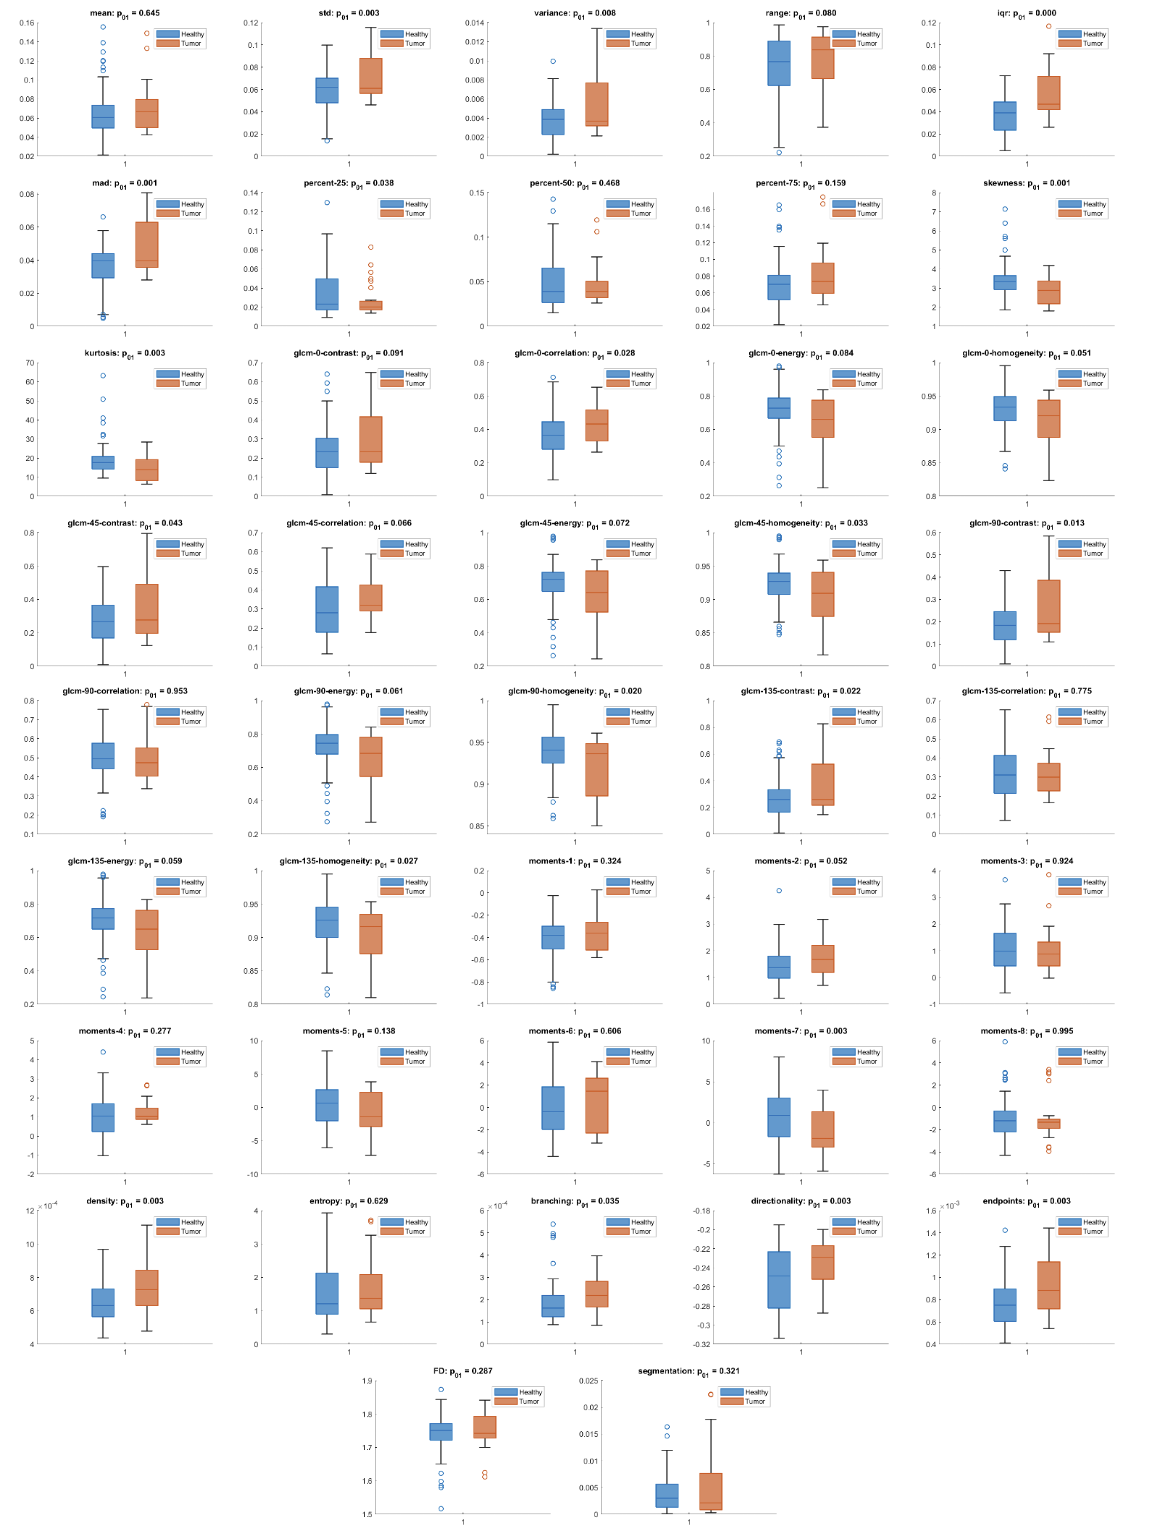



## Feature Models

In [ ]:
def train_test_feature_model(train_X, train_y, test_X, test_y, model_name):
    """
    Trains and tests feature-based models
    """
    print(model_name)
    
    if 'svm' in model_name:
        model = svm.SVC(kernel = 'rbf')
    if 'rf' in model_name:
        model = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', max_depth = 100)
    if 'ada' in model_name:
        model = AdaBoostClassifier(n_estimators=100, estimator = DecisionTreeClassifier(max_depth=50))
    if 'nb' in model_name:
        model = GaussianNB()
    
    # Hyperparameter tuning
    #params = {'n_estimators':[50,100,500,1000], 'criterion':('gini', 'entropy', 'log_loss'), 'max_depth':[50,100,1000, None]}
    #model = GridSearchCV(RandomForestClassifier(), params)
    #model.fit(train_X, train_y)
    
    # Train and test model
    model.fit(train_X, train_y)
    train_pred = model.predict(train_X)
    print("Train accuracy:", metrics.accuracy_score(train_y, train_pred))
    print("Train precision:", metrics.precision_score(train_y, train_pred))
    print("Train recall:", metrics.recall_score(train_y, train_pred))
    print("Train f1 score:", metrics.f1_score(train_y, train_pred))
    
    test_pred = model.predict(test_X)
    print("Test accuracy:", metrics.accuracy_score(test_y, test_pred))
    print("Test precision:", metrics.precision_score(test_y, test_pred))
    print("Test recall:", metrics.recall_score(test_y, test_pred))
    print("Test f1 score:", metrics.f1_score(test_y, test_pred))

    with open('/content/drive/MyDrive/BE 205/models/features/'+model_name+'.pkl','wb') as f:
        pickle.dump(model,f)

    # Confusion matrix
    conf_matrix = confusion_matrix(test_y, test_pred)
    normalized_conf_matrix = [] 
    for i in range(len(conf_matrix)):
        normalized_conf_matrix.append(conf_matrix[i] / np.sum(conf_matrix[i]))

    sns.set(font_scale=0.5)
    plt.figure()
    s = sns.heatmap(normalized_conf_matrix, cmap='Blues', annot = True, fmt=".2f",
                    xticklabels = ['Healthy', 'Cancer'], yticklabels = ['Healthy', 'Cancer'])
    s.set(xlabel='Predicted', ylabel = 'True')

    plt.figure()
    s = sns.heatmap(conf_matrix, cmap='Blues', annot = True, fmt=".0f",
                    xticklabels = ['Healthy', 'Cancer'], yticklabels = ['Healthy', 'Cancer'])
    s.set(xlabel='Predicted', ylabel = 'True')

    # ROC curve
    display = RocCurveDisplay.from_predictions(test_y, test_pred)

    # Precision recall curve
    display = PrecisionRecallDisplay.from_estimator(model, test_X, test_y, name=model_name)

svm
Train accuracy: 0.7916666666666666
Train precision: 1.0
Train recall: 0.4230769230769231
Train f1 score: 0.5945945945945945
Test accuracy: 0.7857142857142857
Test precision: 0.3333333333333333
Test recall: 0.2
Test f1 score: 0.25


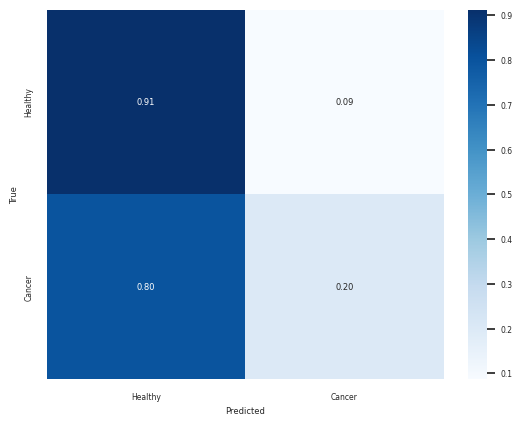

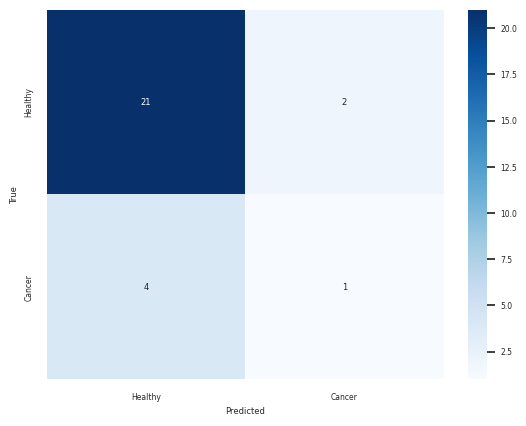

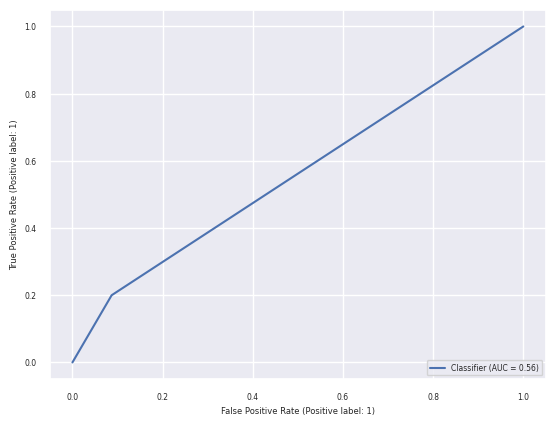

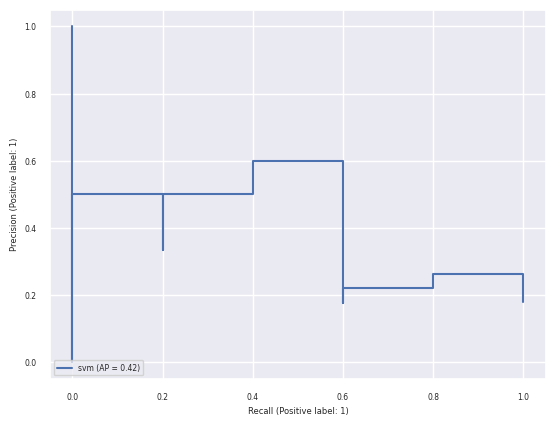

In [ ]:
train_test_feature_model(train_X, train_y, test_X, test_y, 'svm')

rf
Train accuracy: 1.0
Train precision: 1.0
Train recall: 1.0
Train f1 score: 1.0
Test accuracy: 0.8214285714285714
Test precision: 0.0
Test recall: 0.0
Test f1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


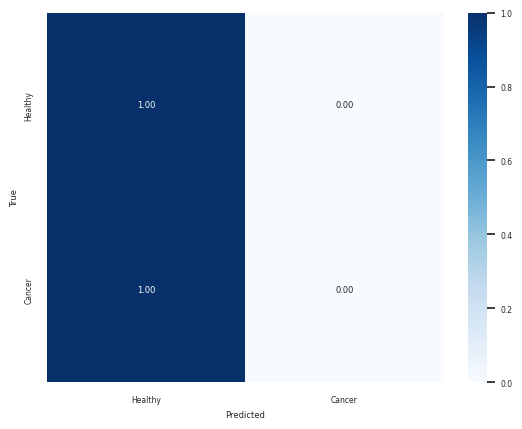

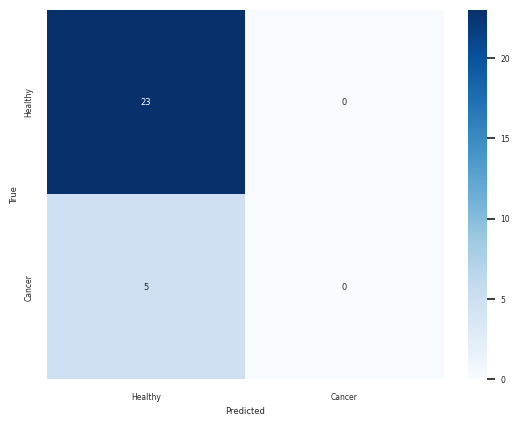

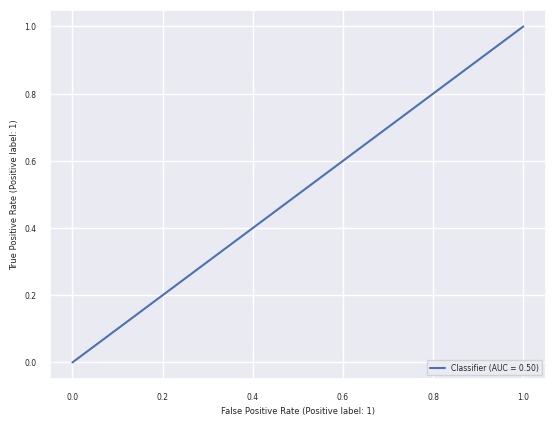

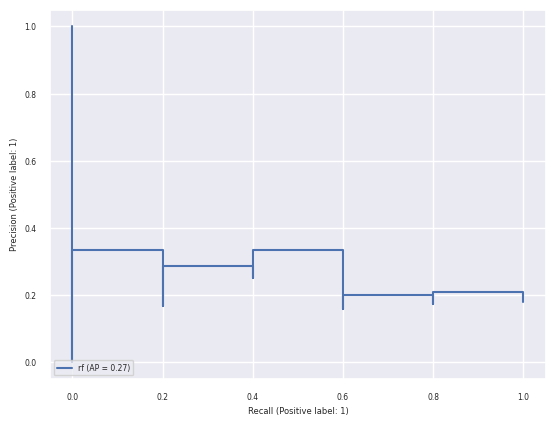

In [ ]:
train_test_feature_model(train_X, train_y, test_X, test_y, 'rf')

ada
Train accuracy: 1.0
Train precision: 1.0
Train recall: 1.0
Train f1 score: 1.0
Test accuracy: 0.6785714285714286
Test precision: 0.16666666666666666
Test recall: 0.2
Test f1 score: 0.1818181818181818


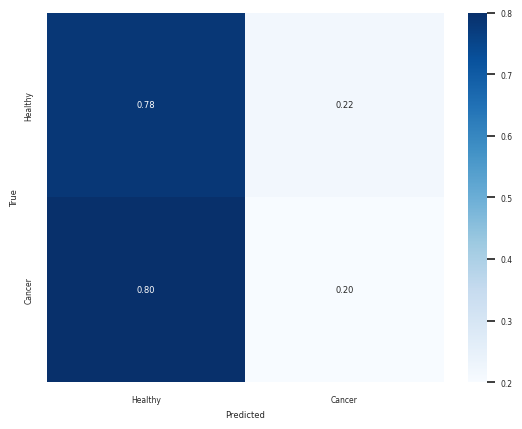

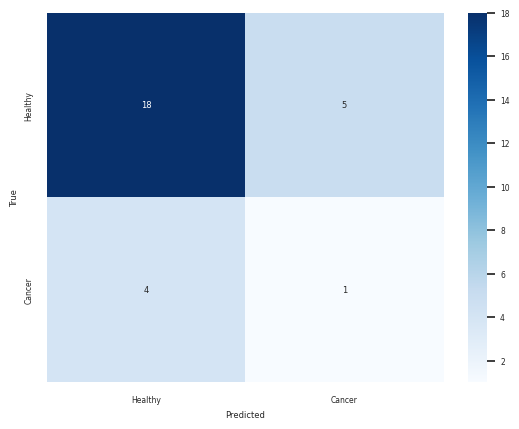

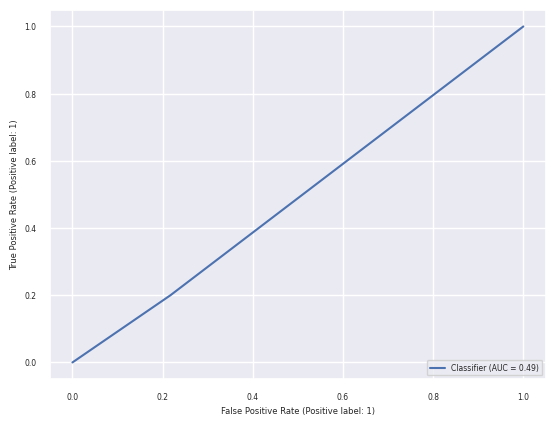

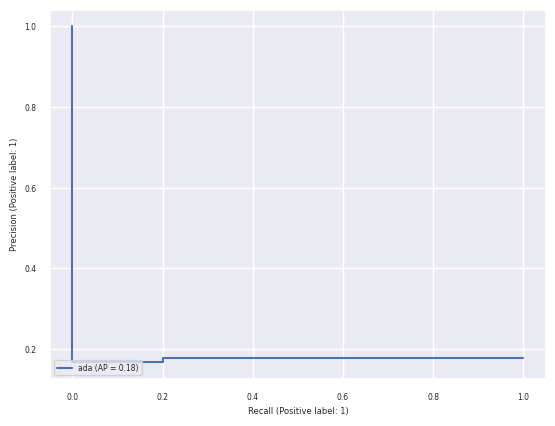

In [ ]:
train_test_feature_model(train_X, train_y, test_X, test_y, 'ada')

nb
Train accuracy: 0.7083333333333334
Train precision: 0.6086956521739131
Train recall: 0.5384615384615384
Train f1 score: 0.5714285714285715
Test accuracy: 0.6428571428571429
Test precision: 0.0
Test recall: 0.0
Test f1 score: 0.0


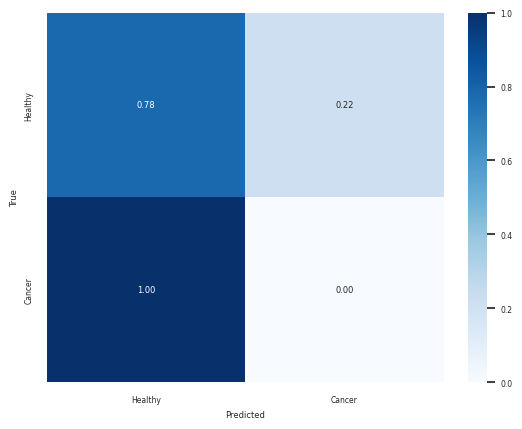

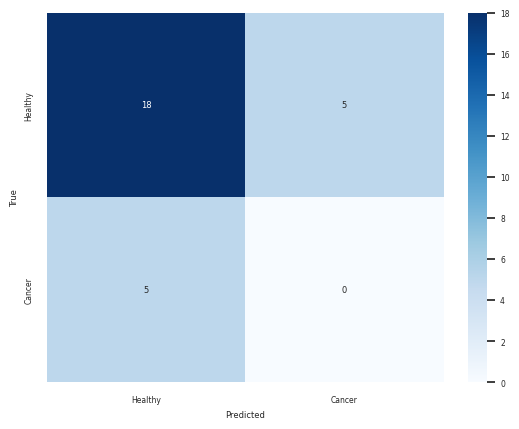

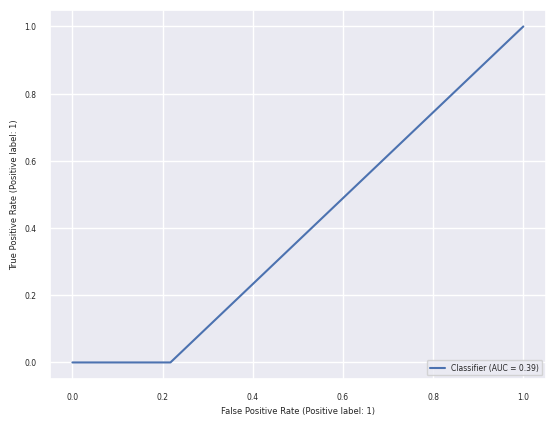

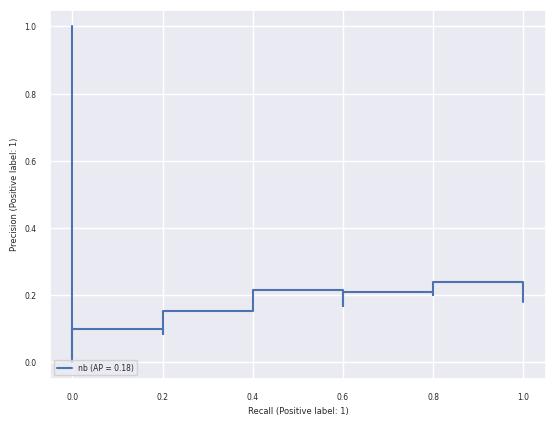

In [ ]:
train_test_feature_model(train_X, train_y, test_X, test_y, 'nb')

# Approach 2: Direct Image-Based Models

Beyond just extracted features, the entire MAP image data can be used to train deep learning models from scratch. However, there are limitations to expected performance due to small dataset size, even with data augmentation. 

## Load data

In [ ]:
def load_data(folder):
    data = []
    labels = []
    for root, dirs, files in os.walk(folder):
        for filename in files:
            f = os.path.join(root, filename)
            if 'labeled_section' in f:
                img = scipy.io.loadmat(f)
                img = np.array(img['section_rgb'])
                #img = (img - np.min(img))/(np.max(img) - np.min(img))
                data.append(img)

                label = f.split('=')[1]
                label = int(label[0:1])
                labels.append(label)
    data = np.asarray(data)
    labels = np.asarray(labels)
    return data, labels

train_data, train_labels = load_data('drive/MyDrive/BE 205/breast_pact/train/')
test_data, test_labels = load_data('drive/MyDrive/BE 205/breast_pact/test')
print('Train data size: ' + str(np.shape(train_data)))
print('Train labels size: ' + str(np.shape(train_labels)))
print('Train data classes: ' + str(sum(train_labels == 0)) + ' healthy, ' + str(sum(train_labels == 1)) + ' tumor')
print('------------------------------------------')
print('Test data size: ' + str(np.shape(test_data)))
print('Test data size: ' + str(np.shape(test_labels)))
print('Test data classes: ' + str(sum(test_labels == 0)) + ' healthy, ' + str(sum(test_labels == 1)) + ' tumor')

Train data size: (72, 256, 256, 3)
Train labels size: (72,)
Train data classes: 46 healthy, 26 tumor
------------------------------------------
Test data size: (28, 256, 256, 3)
Test data size: (28,)
Test data classes: 23 healthy, 5 tumor


In [ ]:
# Visualize example images
fig, axes = plt.subplots(4, 2, figsize=(10,15))
for i in range(8):
    axes.flatten()[i].imshow(train_data[i])
    axes.flatten()[i].set_title('Label ' + str(train_labels[i]))

## Pre-processing / Data augmentation

In [ ]:
# Data Augmentation: example of augmentation of 1 image
img_augmentation = Sequential(
    [
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomRotation(factor=0.2)
    ],
)
train_ds = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(train_data, dtype = tf.float32), tf.keras.utils.to_categorical(train_labels)))
test_ds = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(test_data, dtype = tf.float32), tf.keras.utils.to_categorical(test_labels)))

# Visualize augmented images
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy())
        plt.title("{}".format(label.numpy()))
        plt.axis("off")

In [ ]:
def process_dataset(ds, augment = False, shuffle = True):
    """
    Performs pre-processing (data augmentation, shuffling) on the given dataset
    """
    # Augment data
    img_augmentation = Sequential([
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomRotation(factor=0.2)
    ])

    ds = ds.batch(1)
    if augment:
        augmented_ds = copy(ds)
        for i in range(6):
            augmented_imgs = ds.map(lambda x, y: (img_augmentation(x, training=True), y))
            augmented_ds = augmented_ds.concatenate(augmented_imgs) 
        ds = augmented_ds

    # Shuffle data
    if shuffle:
        ds = ds.shuffle(1000)

    # Rescale pixel values
    #rescale = layers.Rescaling(1./255)
    #ds = ds.map(lambda x, y: (rescale(x), y))

    ds = ds.unbatch()
    ds = ds.batch(16)
        
    return ds.prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(train_data, dtype = tf.float32), tf.keras.utils.to_categorical(train_labels)))
test_ds = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(test_data, dtype = tf.float32), tf.keras.utils.to_categorical(test_labels)))

train_ds = process_dataset(train_ds, augment = True, shuffle = True)
test_ds = process_dataset(test_ds)

labels = np.concatenate([y for x, y in train_ds], axis = 0)
print('Augmented train dataset size: ' + str(len(labels)))
print('Augmented train classes: ' + str(sum(labels == 1)) + ' [healthy, cancer]')
print('----------------------------')
labels = np.concatenate([y for x, y in test_ds], axis = 0)
print('Augmented test dataset size: ' + str(len(labels)))
print('Augmented test classes: ' + str(sum(labels == 1)) + ' [healthy, cancer]')

fig, axes = plt.subplots(4, 2, figsize=(10,15))
i = 0
for image, label in train_ds.take(8):
    axes.flatten()[i].imshow(image[0].numpy())
    axes.flatten()[i].grid(None) 
    axes.flatten()[i].set_title('Label ' + str(label[0].numpy()))
    i = i + 1

## Models
Models adapted from Image Classification Tutorial -- made more shallow due to small training dataset size

In [ ]:
def plot_hist(hist):
    """
    Plots the binary accuracy and loss over training epochs.
    """
    plt.figure()
    sns.set(font_scale=0.5)
    plt.plot(hist.history["binary_accuracy"])
    plt.plot(hist.history["val_binary_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

    plt.figure()
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Model Loss")
    plt.ylabel("BCE Loss")
    plt.xlabel("Epoch")
    plt.legend(["train", "validation"], loc="upper right")
    plt.show()

def train_model(model, model_path, model_name, train_ds, test_ds, lr, epochs, class_weights, cb = True):
    """
    Trains a classifier model in tensorflow
    """
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(), 
                           tf.keras.metrics.Recall(class_id=0), 
                           tf.keras.metrics.Recall(class_id=1), 
                           tf.keras.metrics.Precision(class_id=0), 
                           tf.keras.metrics.Precision(class_id=1)])
    
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
            model_path, monitor='val_loss',
            save_best_only=True, verbose=1,
            save_weights_only=False)
    ]

    callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, verbose=1,
            patience=3, min_lr=1e-7)
    )

    if cb: 
      hist = model.fit(train_ds, validation_data=test_ds, epochs=epochs, 
                     class_weight = class_weights, callbacks = callbacks)
    else:
      hist = model.fit(train_ds, validation_data=test_ds, epochs=epochs, 
                     class_weight = class_weights)

    plot_hist(hist)

    model.save('/content/drive/MyDrive/BE 205/models/image_models/'+model_name+'_model.h5')

    return model

def evaluate_model(train_X, train_y, test_X, test_y, model):
    """
    Evaluates on test set: metrics, confusion matrix, ROC curve
    """
    # Comparison to train metrics
    train_pred = model.predict(train_X)
    train_pred = tf.math.argmax(train_pred, axis=-1).numpy()
    accuracy = 1*(train_pred == train_y).mean()
    recall = recall_score(train_y, train_pred)
    precision = precision_score(train_y, train_pred)
    f1 = f1_score(train_y, train_pred)

    print('Train Accuracy: {}'.format(accuracy))
    print('Train Precision: {}'.format(precision))
    print('Train Recall: {}'.format(recall))
    print('Train F1 Score: {}'.format(f1))

    pred = model.predict(test_X)
    pred = tf.math.argmax(pred, axis=-1).numpy()
    y = test_y
    
    # Classification report
    print(classification_report(test_y, pred))
    #display = PrecisionRecallDisplay.from_predictions(test_y, pred)

    accuracy = 1*(pred == y).mean()
    recall = recall_score(test_y, pred)
    precision = precision_score(test_y, pred)
    f1 = f1_score(test_y, pred)

    print('Test Accuracy: {}'.format(accuracy))
    print('Test Precision: {}'.format(precision))
    print('Test Recall: {}'.format(recall))
    print('Test F1 Score: {}'.format(f1))

    # Confusion matrix
    conf_matrix = confusion_matrix(test_y, pred)
    normalized_conf_matrix = [] 
    for i in range(len(conf_matrix)):
        normalized_conf_matrix.append(conf_matrix[i] / np.sum(conf_matrix[i]))

    sns.set(font_scale=0.5)
    plt.figure()
    s = sns.heatmap(normalized_conf_matrix, cmap='Blues', annot = True, fmt=".2f",
                    xticklabels = ['Healthy', 'Tumor'], yticklabels = ['Healthy', 'Tumor'])
    s.set(xlabel='Predicted', ylabel = 'True')

    plt.figure()
    s = sns.heatmap(conf_matrix, cmap='Blues', annot = True, fmt=".0f",
                    xticklabels = ['Healthy', 'Tumor'], yticklabels = ['Healthy', 'Tumor'])
    s.set(xlabel='Predicted', ylabel = 'True')

    # ROC curve
    display = RocCurveDisplay.from_predictions(test_y, pred)

    return pred, y, accuracy

### Linear Classifier

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 linear_classifier_input (In  [(None, 256, 256, 3)]    0         
 putLayer)                                                       
                                                                 
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 2)                 393218    
                                                                 
 softmax (Softmax)           (None, 2)                 0         
                                                                 
Total params: 393,218
Trainable params: 393,218
Non-trainable params: 0
_________________________________________________________________


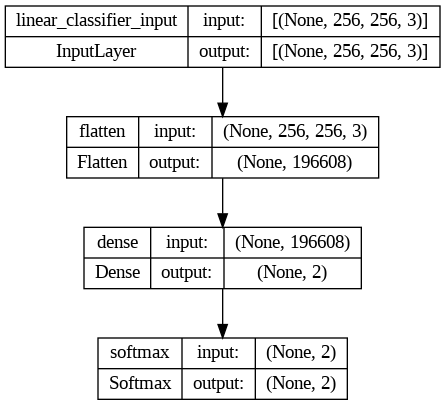

In [ ]:
def create_linear_classifier():
    inputs = Input((256, 256,3),
                   name='linear_classifier_input')
    x = Flatten()(inputs)
    x = Dense(2)(x)
    x = Softmax(axis=-1)(x)
    model = Model(inputs=inputs, outputs=x)
    return model

linear_classifier = create_linear_classifier()
linear_classifier.summary()
plot_model(linear_classifier, to_file = '/content/drive/MyDrive/BE 205/models/image_models/linear.png', show_shapes=True)

Epoch 1/100
32/32 [==============================] - 13s 31ms/step - loss: 1.6157 - binary_accuracy: 0.5972 - recall_2: 0.5062 - recall_3: 0.7582 - precision_2: 0.7874 - precision_3: 0.4646 - val_loss: 1.5093 - val_binary_accuracy: 0.4643 - val_recall_2: 0.3478 - val_recall_3: 1.0000 - val_precision_2: 1.0000 - val_precision_3: 0.2500
Epoch 2/100
32/32 [==============================] - 8s 13ms/step - loss: 1.6046 - binary_accuracy: 0.6111 - recall_2: 0.5186 - recall_3: 0.7747 - precision_2: 0.8029 - precision_3: 0.4764 - val_loss: 2.7016 - val_binary_accuracy: 0.3214 - val_recall_2: 0.1739 - val_recall_3: 1.0000 - val_precision_2: 1.0000 - val_precision_3: 0.2083
Epoch 3/100
32/32 [==============================] - 7s 13ms/step - loss: 1.6910 - binary_accuracy: 0.5853 - recall_2: 0.4907 - recall_3: 0.7527 - precision_2: 0.7783 - precision_3: 0.4551 - val_loss: 3.6534 - val_binary_accuracy: 0.2500 - val_recall_2: 0.0870 - val_recall_3: 1.0000 - val_precision_2: 1.0000 - val_precision_3

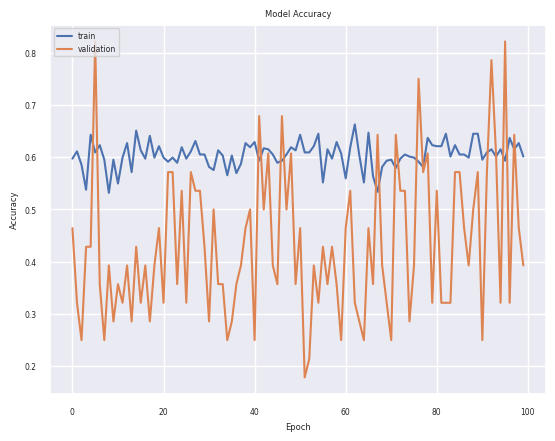

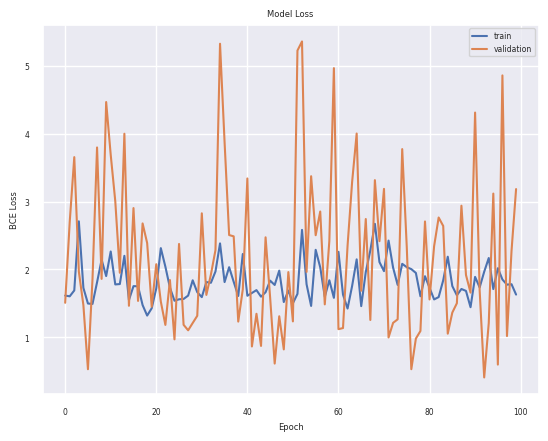

3/3 [==============================] - 0s 9ms/step
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1 Score: 1.0
1/1 [==============================] - 0s 36ms/step
              precision    recall  f1-score   support

           0       1.00      0.26      0.41        23
           1       0.23      1.00      0.37         5

    accuracy                           0.39        28
   macro avg       0.61      0.63      0.39        28
weighted avg       0.86      0.39      0.41        28

Test Accuracy: 0.39285714285714285
Test Precision: 0.22727272727272727
Test Recall: 1.0
Test F1 Score: 0.37037037037037035


(array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 0]),
 array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0]),
 0.39285714285714285)

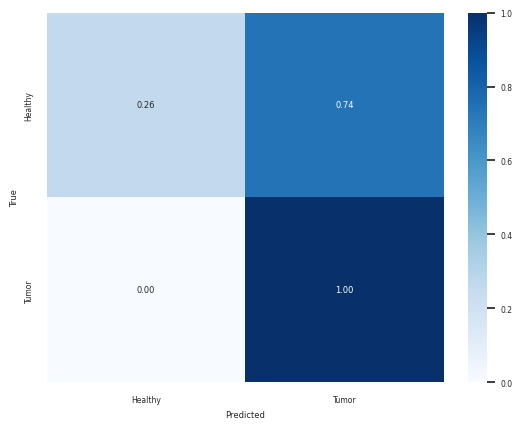

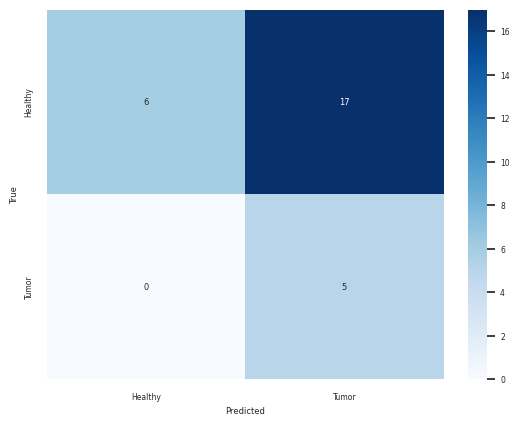

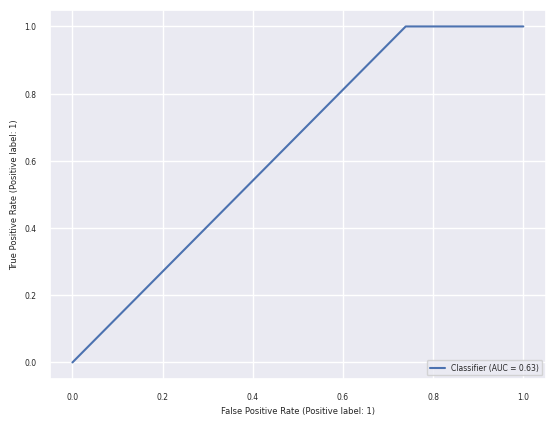

In [ ]:
class_weights = {0: 1., 1: 3.}
train_model(linear_classifier, '/content/drive/MyDrive/BE 205/models/image_models/','linear', train_ds, test_ds, 0.001, 100, class_weights, cb = False)
evaluate_model(train_data, train_labels, test_data, test_labels, linear_classifier)

### Fully-connected classifier

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc_classifier_input (InputL  [(None, 256, 256, 3)]    0         
 ayer)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 196608)            0         
                                                                 
 dense_1 (Dense)             (None, 64)                12582976  
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 32)                2080

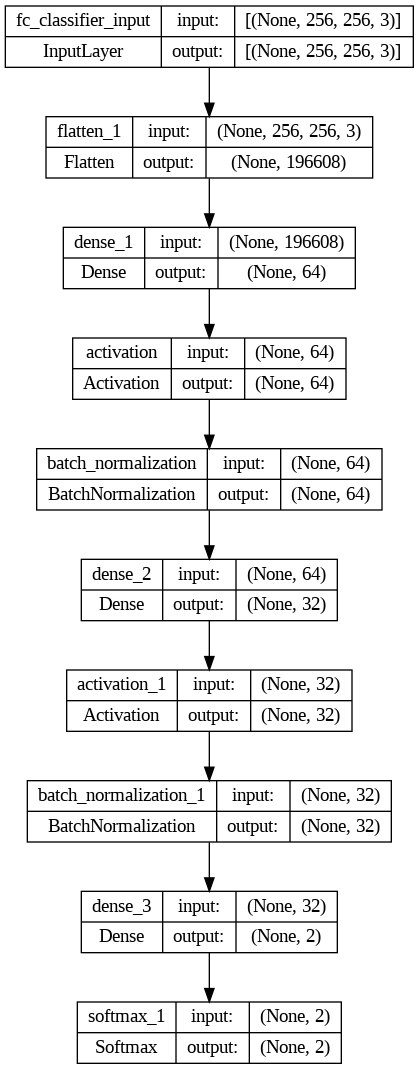

In [ ]:
def create_fc_classifier():
    inputs = Input((256, 256, 3),
                   name='fc_classifier_input')
    x = Flatten()(inputs)
    x = Dense(64)(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dense(2)(x)
    x = Softmax(axis=-1)(x)
    model = Model(inputs=inputs, outputs=x)
    return model

fc_classifier = create_fc_classifier()
fc_classifier.summary()
plot_model(fc_classifier, to_file = '/content/drive/MyDrive/BE 205/models/image_models/fc.png', show_shapes=True)

Epoch 1/100
32/32 [==============================] - 12s 32ms/step - loss: 1.2367 - binary_accuracy: 0.6250 - recall_4: 0.5870 - recall_5: 0.6923 - precision_4: 0.7714 - precision_5: 0.4865 - val_loss: 5.4595 - val_binary_accuracy: 0.1786 - val_recall_4: 0.0000e+00 - val_recall_5: 1.0000 - val_precision_4: 0.0000e+00 - val_precision_5: 0.1786
Epoch 2/100
32/32 [==============================] - 7s 18ms/step - loss: 0.9241 - binary_accuracy: 0.6825 - recall_4: 0.6056 - recall_5: 0.8187 - precision_4: 0.8553 - precision_5: 0.5399 - val_loss: 2.6239 - val_binary_accuracy: 0.1786 - val_recall_4: 0.0000e+00 - val_recall_5: 1.0000 - val_precision_4: 0.0000e+00 - val_precision_5: 0.1786
Epoch 3/100
32/32 [==============================] - 8s 20ms/step - loss: 0.8043 - binary_accuracy: 0.7183 - recall_4: 0.6211 - recall_5: 0.8901 - precision_4: 0.9091 - precision_5: 0.5704 - val_loss: 1.7906 - val_binary_accuracy: 0.2143 - val_recall_4: 0.0435 - val_recall_5: 1.0000 - val_precision_4: 1.0000 -

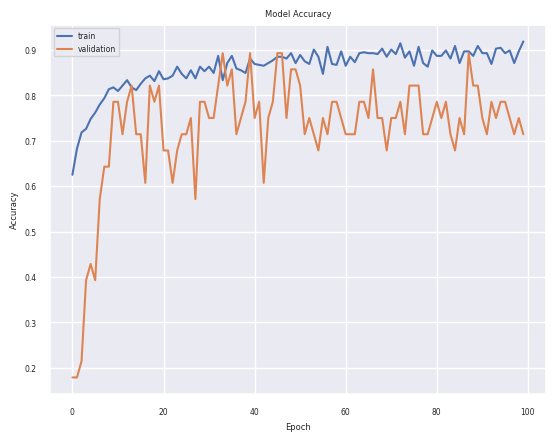

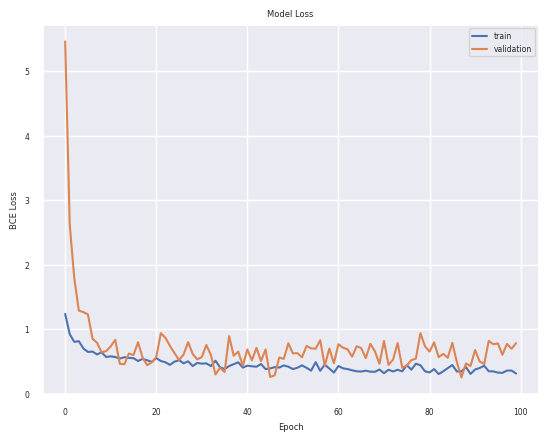

3/3 [==============================] - 0s 10ms/step
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1 Score: 1.0
1/1 [==============================] - 0s 37ms/step
              precision    recall  f1-score   support

           0       0.94      0.70      0.80        23
           1       0.36      0.80      0.50         5

    accuracy                           0.71        28
   macro avg       0.65      0.75      0.65        28
weighted avg       0.84      0.71      0.75        28

Test Accuracy: 0.7142857142857143
Test Precision: 0.36363636363636365
Test Recall: 0.8
Test F1 Score: 0.5000000000000001


(array([1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 1]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 1]),
 0.7142857142857143)

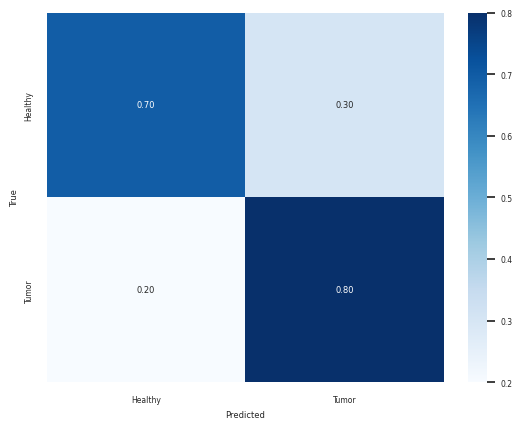

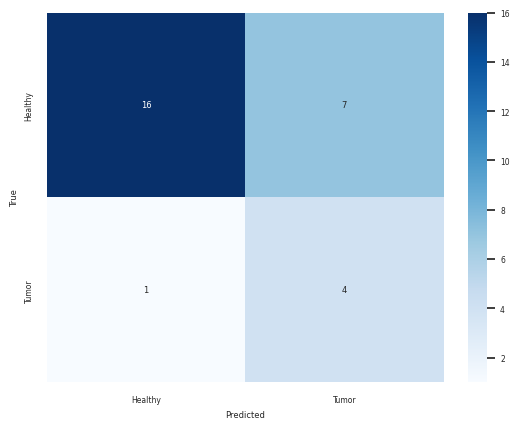

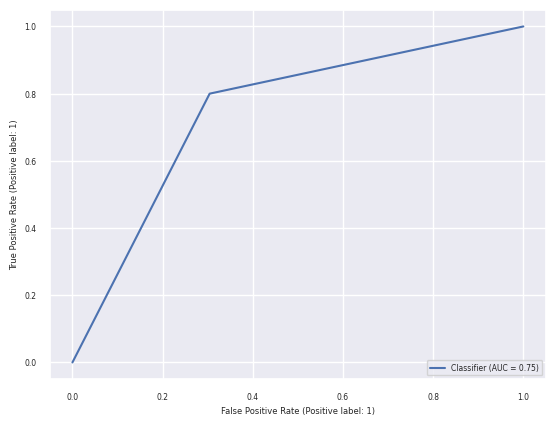

In [ ]:
class_weights = {0: 1., 1: 3.}
train_model(fc_classifier, '/content/drive/MyDrive/BE 205/models/image_models/','fc', train_ds, test_ds, 0.001, 100, class_weights, cb = False)
evaluate_model(train_data, train_labels, test_data, test_labels, fc_classifier)

### Conv (CNN) classifier

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_classifier_input (Inpu  [(None, 256, 256, 3)]    0         
 tLayer)                                                         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 activation_2 (Activation)   (None, 256, 256, 64)      0         
                                                                 
 batch_normalization_2 (Batc  (None, 256, 256, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                           

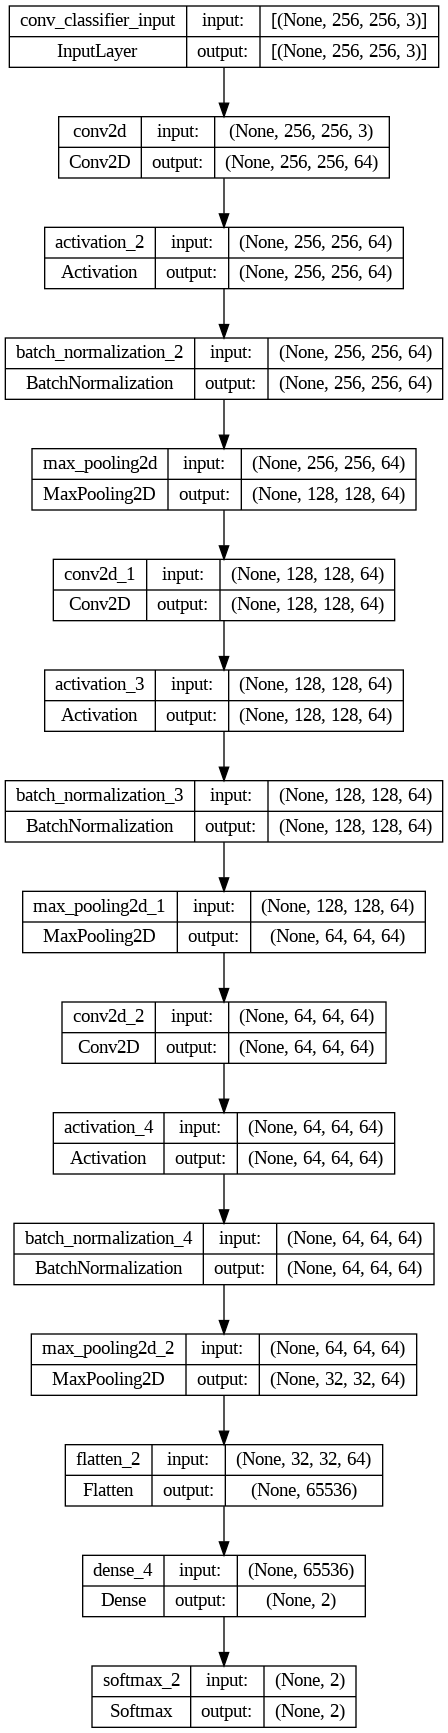

In [ ]:
def create_conv_classifier():
    inputs = Input((256, 256,3),
                   name='conv_classifier_input')
    x = Conv2D(64, (3,3), padding='SAME')(inputs)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPool2D(strides=(2,2))(x) # 16, 16
    x = Conv2D(64, (3,3), padding='SAME')(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPool2D(strides=(2,2))(x) # 8,8
    x = Conv2D(64, (3,3), padding='SAME')(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPool2D(strides=(2,2))(x) # 4,4
    x = Flatten()(x)
    x = Dense(2)(x)
    x = Softmax(axis=-1)(x)
    model = Model(inputs=inputs, outputs=x)
    return model

conv_classifier = create_conv_classifier()
conv_classifier.summary()
plot_model(conv_classifier, to_file = '/content/drive/MyDrive/BE 205/models/image_models/conv.png', show_shapes=True)

Epoch 1/100
32/32 [==============================] - 22s 112ms/step - loss: 8.5739 - binary_accuracy: 0.5218 - recall_6: 0.4006 - recall_7: 0.7363 - precision_6: 0.7288 - precision_7: 0.4098 - val_loss: 2.7388 - val_binary_accuracy: 0.8214 - val_recall_6: 1.0000 - val_recall_7: 0.0000e+00 - val_precision_6: 0.8214 - val_precision_7: 0.0000e+00
Epoch 2/100
32/32 [==============================] - 9s 67ms/step - loss: 6.3322 - binary_accuracy: 0.5952 - recall_6: 0.4161 - recall_7: 0.9121 - precision_6: 0.8933 - precision_7: 0.4689 - val_loss: 2.7388 - val_binary_accuracy: 0.8214 - val_recall_6: 1.0000 - val_recall_7: 0.0000e+00 - val_precision_6: 0.8214 - val_precision_7: 0.0000e+00
Epoch 3/100
32/32 [==============================] - 8s 63ms/step - loss: 6.2670 - binary_accuracy: 0.6052 - recall_6: 0.4286 - recall_7: 0.9176 - precision_6: 0.9020 - precision_7: 0.4758 - val_loss: 2.7388 - val_binary_accuracy: 0.8214 - val_recall_6: 1.0000 - val_recall_7: 0.0000e+00 - val_precision_6: 0.8

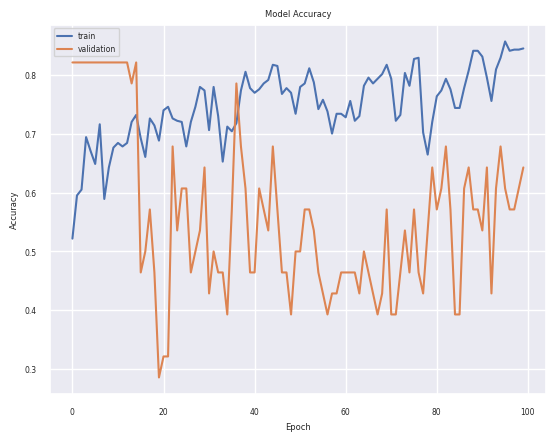

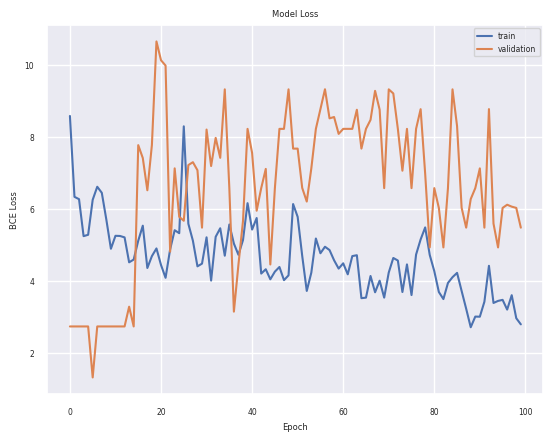

3/3 [==============================] - 1s 21ms/step
Train Accuracy: 0.875
Train Precision: 0.7428571428571429
Train Recall: 1.0
Train F1 Score: 0.8524590163934427
1/1 [==============================] - 1s 645ms/step
              precision    recall  f1-score   support

           0       0.93      0.61      0.74        23
           1       0.31      0.80      0.44         5

    accuracy                           0.64        28
   macro avg       0.62      0.70      0.59        28
weighted avg       0.82      0.64      0.68        28

Test Accuracy: 0.6428571428571429
Test Precision: 0.3076923076923077
Test Recall: 0.8
Test F1 Score: 0.4444444444444444


(array([1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 1, 0, 1]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 1]),
 0.6428571428571429)

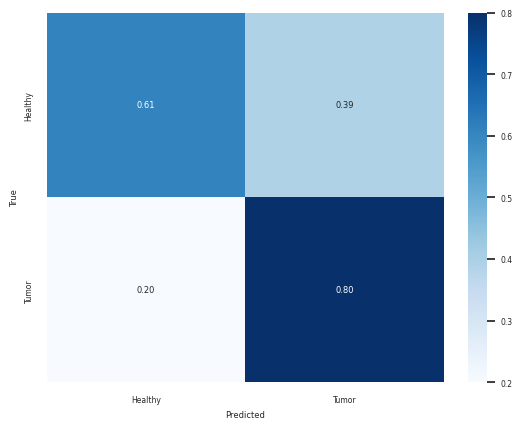

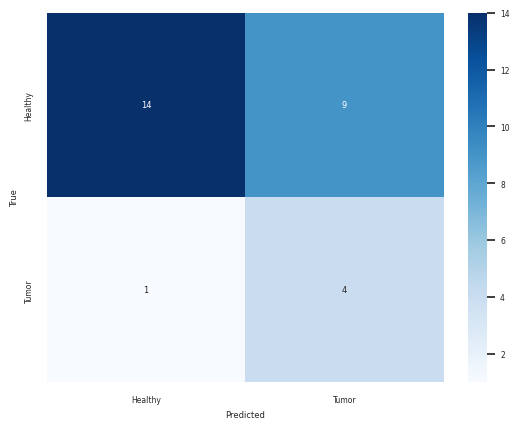

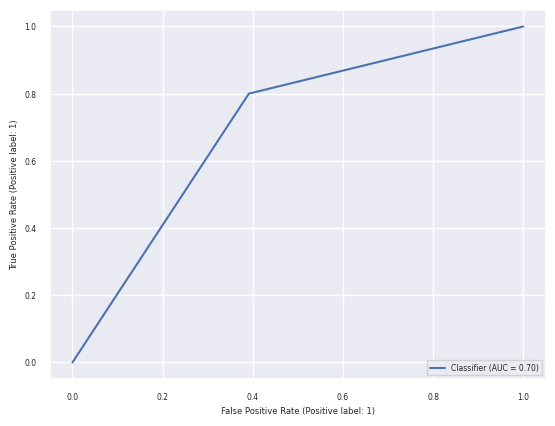

In [ ]:
class_weights = {0: 1., 1: 3.}
train_model(conv_classifier, '/content/drive/MyDrive/BE 205/models/image_models/','conv', train_ds, test_ds, 0.001, 100, class_weights, cb = False)
evaluate_model(train_data, train_labels, test_data, test_labels, conv_classifier)

# Approach 3: Transfer Learning for Image-Based Models
Due to small dataset size, another approach is to use a pre-trained model (trained on a large  external image dataset) and use transfer learning to tune the model to our data. Most of the layers of the pre-trained model are frozen (weights will not be updated during training) and used to extract image features from our input PA images. These features are then fed into the final layers, which are trained. 

## Transfer Learning: Resnet50

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

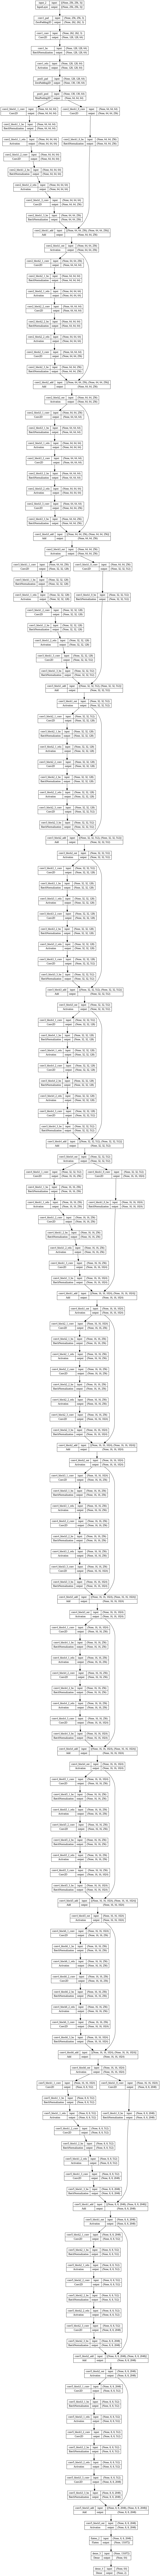

In [ ]:
# Transfer learning with ResNet
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256,256,3)
)
base_model.trainable = False

# Add final layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(64, activation='relu')(x)
x = Dense(2, activation='sigmoid')(x)
resnet_model = Model(inputs = base_model.inputs, outputs = x)
resnet_model.summary()
plot_model(resnet_model, to_file = '/content/drive/MyDrive/BE 205/models/resnet_models/resnet.png', show_shapes=True)


Epoch 1/100
32/32 [==============================] - 14s 110ms/step - loss: 2.1957 - binary_accuracy: 0.4683 - recall_6: 0.2205 - recall_7: 0.3571 - precision_6: 0.6339 - precision_7: 0.3385 - val_loss: 0.6938 - val_binary_accuracy: 0.5000 - val_recall_6: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_precision_6: 0.0000e+00 - val_precision_7: 0.0000e+00
Epoch 2/100
32/32 [==============================] - 8s 73ms/step - loss: 1.1917 - binary_accuracy: 0.4167 - recall_6: 0.0000e+00 - recall_7: 0.6264 - precision_6: 0.0000e+00 - precision_7: 0.3654 - val_loss: 0.6991 - val_binary_accuracy: 0.1786 - val_recall_6: 0.0000e+00 - val_recall_7: 1.0000 - val_precision_6: 0.0000e+00 - val_precision_7: 0.1786
Epoch 3/100
32/32 [==============================] - 9s 71ms/step - loss: 1.1881 - binary_accuracy: 0.3611 - recall_6: 0.0000e+00 - recall_7: 1.0000 - precision_6: 0.0000e+00 - precision_7: 0.3611 - val_loss: 0.7045 - val_binary_accuracy: 0.1786 - val_recall_6: 0.0000e+00 - val_recall_7: 1.000

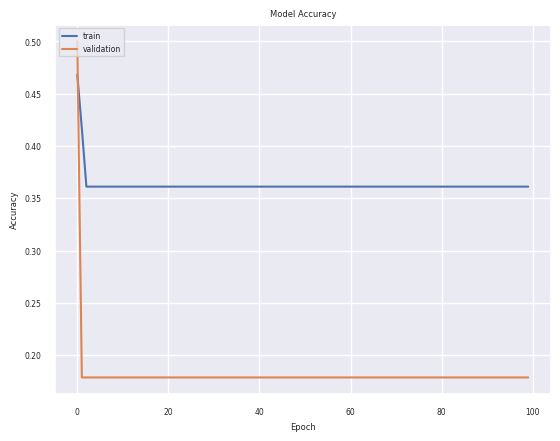

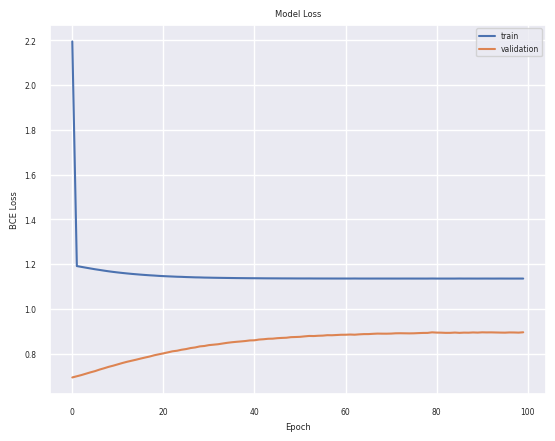

3/3 [==============================] - 3s 66ms/step
Train Accuracy: 0.3611111111111111
Train Precision: 0.3611111111111111
Train Recall: 1.0
Train F1 Score: 0.5306122448979591
1/1 [==============================] - 1s 1s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.18      1.00      0.30         5

    accuracy                           0.18        28
   macro avg       0.09      0.50      0.15        28
weighted avg       0.03      0.18      0.05        28

Test Accuracy: 0.17857142857142858
Test Precision: 0.17857142857142858
Test Recall: 1.0
Test F1 Score: 0.30303030303030304


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]),
 array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0]),
 0.17857142857142858)

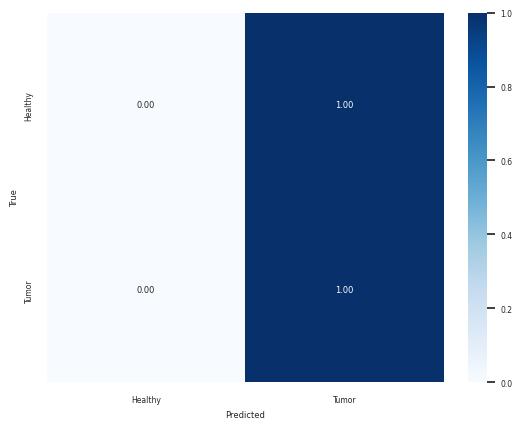

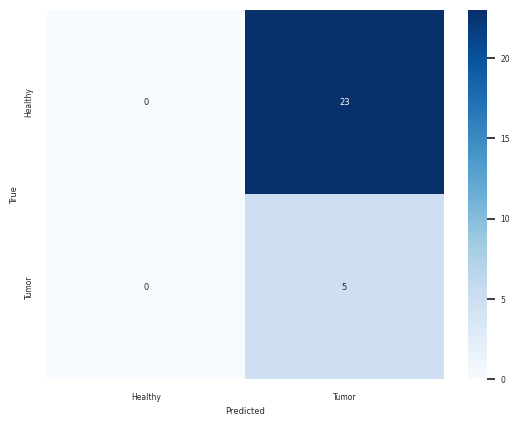

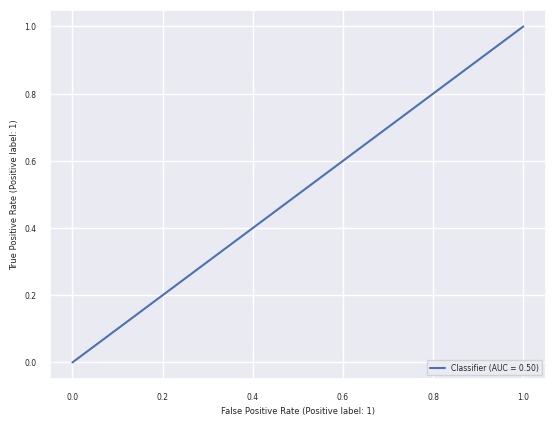

In [ ]:
train_model(resnet_model, '/content/drive/MyDrive/BE 205/models/resnet', 'resnet', train_ds, test_ds, 
            0.001, 100, class_weights, cb=False)
evaluate_model(train_data, train_labels, test_data, test_labels, resnet_model)

# Final Results Summary



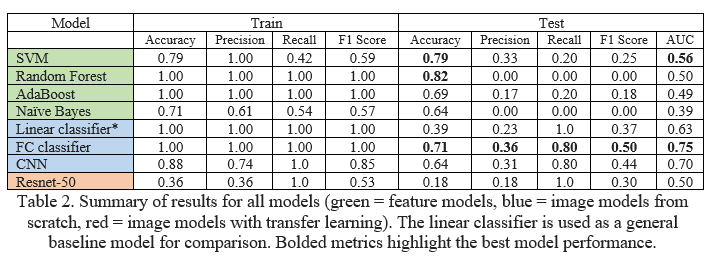